# Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unrar x "/content/drive/MyDrive/Untitled folder/NN_HW2_Face_Emotion.rar" "/content/FER/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/FER/TRAIN/fear/image0000694.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000701.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000777.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000808.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000815.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000842.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000843.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0000915.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0001001.jpg                      24%  OK 
Extracting  /content/FER/TRAIN/fear/image0001038.jpg                      24%  OK 
Extracting  /content/FER/TRAI

# Loading Librarires

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GaussianDropout, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Sequential, load_model
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
# Compile the model
from tensorflow.keras.optimizers import Adam
import numpy as np


# Showing random images

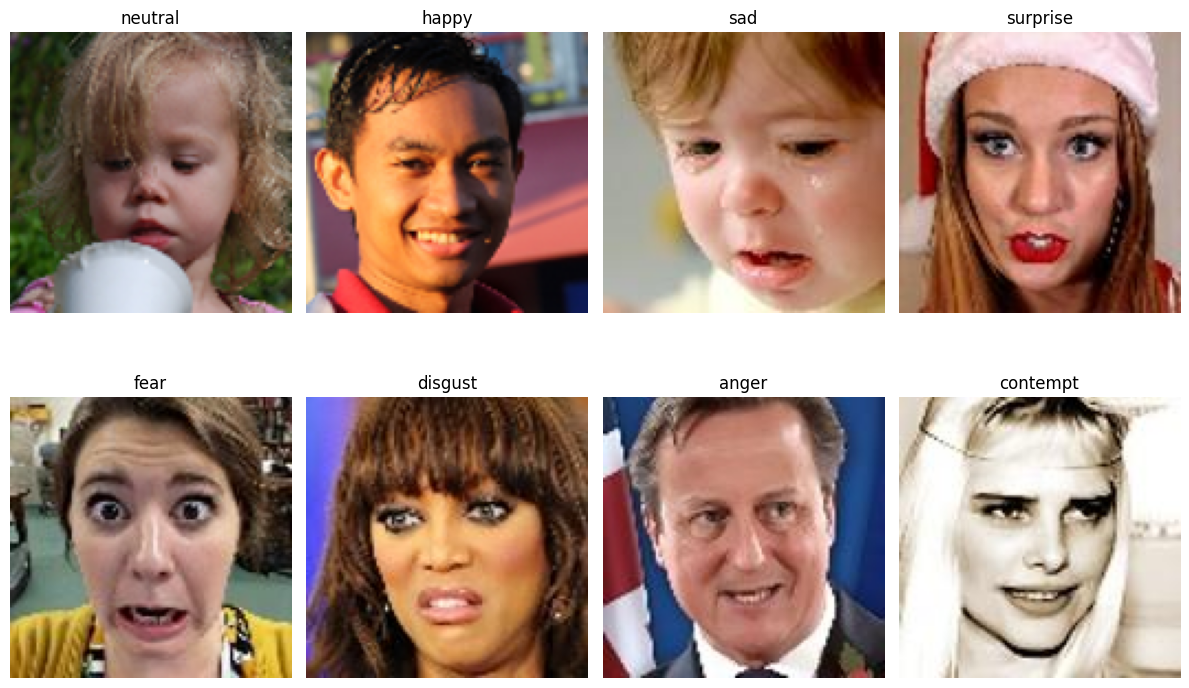

In [5]:


# Path to the directory containing the dataset
dataset_dir = '/content/FER/TRAIN'

# Define the eight classes
classes = ['neutral', 'happy', 'sad', 'surprise', 'fear', 'disgust', 'anger', 'contempt']

# Display one random image from each class
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(dataset_dir, class_name)
    random_image = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, random_image)
    image = load_img(image_path, target_size=(128, 128))  # Adjust target size as needed

    plt.subplot(2, 4, i)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()




# Data Preparation and Augmentation Setup

This code segment outlines the setup for data directories and image preprocessing using the `ImageDataGenerator` in Keras for training and validation sets. It involves:

### Training Set:
- **Directory Setup:**
  - `train_data_dir`: Points to the directory containing training data.
  - `Tune_dir`: Refers to the directory for the tuning dataset.

- **ImageDataGenerator Configuration for Training:**
  - Normalizes pixel values to a range of [0,1] (`rescale=1./255`).
  - Augmentation techniques applied to diversify training samples:
    - Random rotation within 20 degrees (`rotation_range=20`).
    - Horizontal and vertical shifts by 10% (`width_shift_range=0.1`, `height_shift_range=0.1`).
    - Horizontal flipping of images (`horizontal_flip=True`).
  - 80-20 split for validation (`validation_split=0.2`).

### Image Specifications:
- `batch_size`: Set to 400 images per batch.
- `image_size`: Images resized to 128x128 pixels. Adjust as per your image dimensions.

### Data Flow:
- **Training Set Generation:**
  - `train_generator`: Flow of training data, utilizing augmentation parameters.
  - `validation_generator`: Flow of validation data from the training directory.

### Validation Set (Tuning):
- **ImageDataGenerator Configuration for Validation (Tuning) Set:**
  - Similar preprocessing setup as the training set without the validation split.

- **Tuning Set Generation:**
  - `Tune_generator`: Generates the tuning/validation data from the `Tune_dir`.

This code is essential for setting up data pipelines, applying augmentation techniques to enhance model generalization, and preparing datasets for training and validation purposes. Adjust parameters as needed based on your specific classification requirements.

---

In [6]:

# Define the paths to your dataset
train_data_dir = '/content/FER/TRAIN'
Tune_dir = '/content/FER/TUNE'

# Define the ImageDataGenerator for training set with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Define the ImageDataGenerator for validation set (no augmentation)

# Define batch size and image size
batch_size = 400
image_size = (128, 128)  # Adjust this based on your image dimensions

# Generate the training set
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training' # Adjust if using different classification settings
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'# Adjust if using different classification settings
)

Tune_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Generate the validation set
Tune_generator = Tune_datagen.flow_from_directory(
    Tune_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'  # Adjust if using different classification settings
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


## Showing random augmented Image

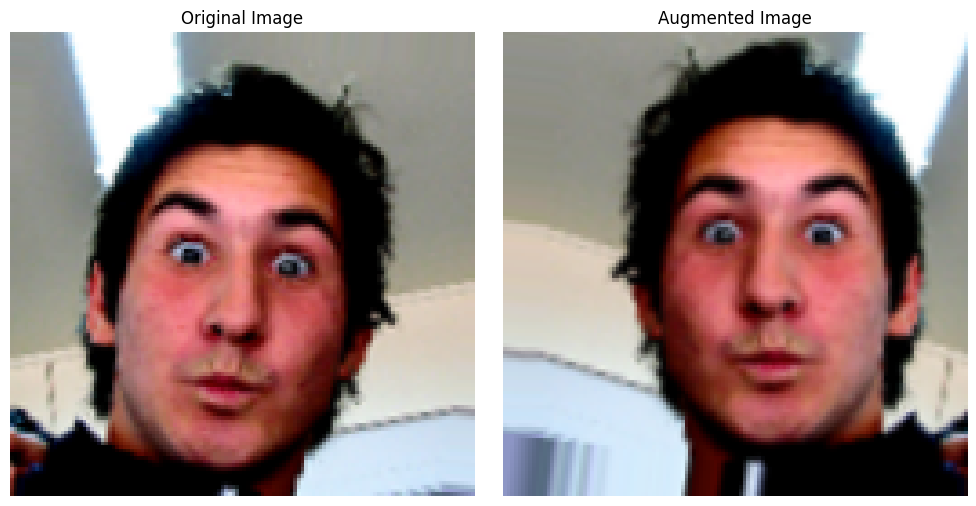

In [ ]:


# Access a batch of original images from the generator
batch = train_generator.next()

# Select a random image from the batch
random_index = np.random.randint(0, batch[0].shape[0])  # Random index within the batch
original_image = batch[0][random_index]  # Original image

# Generate an augmented version of the selected image
augmented_image = train_datagen.random_transform(original_image)

# Display the original and augmented images
plt.figure(figsize=(10, 5))

# Plot original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

# Plot augmented image
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(augmented_image)
plt.axis('off')

plt.tight_layout()
plt.show()



# VGGNet-inspired Convolutional Neural Network

This code cell constructs a deep convolutional neural network (CNN) akin to VGGNet architecture. It consists of five convolutional blocks followed by fully connected layers for classification. Key components include:

- **Convolutional Blocks:** Each block contains two consecutive convolutional layers followed by batch normalization and rectified linear unit (ReLU) activation, emphasizing hierarchical feature extraction.
- **Max Pooling:** After each pair of convolutional layers, max pooling with a pool size of (2, 2) is applied to reduce spatial dimensions.
- **Dropout and Gaussian Dropout:** Dropout regularization is used in fully connected layers with varying rates (between 0.2 and 0.5) to prevent overfitting.
- **Dense Layers:** Two dense layers with 1024 units each, followed by batch normalization, ReLU activation, and dropout, lead to the final classification layer with 8 output units (utilizing softmax activation for multi-class classification).

This architecture aims to learn hierarchical representations from input images and adaptively classify them into one of eight classes, resembling the design principles of VGGNet while incorporating dropout for regularization. Adjusting dropout rates and layer configurations can fine-tune model performance based on the specific dataset and requirements.

---

In [7]:
dropout=(0.2,0.5)
model = Sequential()
# CONV BLOCK 1
model.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(GaussianDropout(dropout[0]))
# CONV BLOCK 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(GaussianDropout(dropout[0]))
# CONV BLOCK 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(GaussianDropout(dropout[0]))
# CONV BLOCK 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(GaussianDropout(dropout[0]))
# CONV BLOCK 5
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(GaussianDropout(dropout[0]))
# flatten
model.add(Flatten())
# dense 1
model.add(Dense(1024, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))
# dense 2
model.add(Dense(1024, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout[1]))
model.add(Dense(8, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      432       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2304      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 128, 128, 16)      0

In [8]:
# Compile the model

batch_size=400
epochs=50
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
train_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
16/16 [==============================] - 76s 3s/step - loss: 2.6606 - accuracy: 0.1369 - val_loss: 2.0832 - val_accuracy: 0.1250
Epoch 2/50
16/16 [==============================] - 49s 3s/step - loss: 2.4312 - accuracy: 0.1403 - val_loss: 2.0962 - val_accuracy: 0.1250
Epoch 3/50
16/16 [==============================] - 49s 3s/step - loss: 2.2892 - accuracy: 0.1570 - val_loss: 2.1120 - val_accuracy: 0.1250
Epoch 4/50
16/16 [==============================] - 49s 3s/step - loss: 2.1853 - accuracy: 0.1694 - val_loss: 2.1200 - val_accuracy: 0.1256
Epoch 5/50
16/16 [==============================] - 48s 3s/step - loss: 2.1504 - accuracy: 0.2005 - val_loss: 2.0808 - val_accuracy: 0.1269
Epoch 6/50
16/16 [==============================] - 47s 3s/step - loss: 2.0737 - accuracy: 0.2058 - val_loss: 2.0844 - val_accuracy: 0.1294
Epoch 7/50
16/16 [==============================] - 49s 3s/step - loss: 2.0424 - accuracy: 0.2173 - val_loss: 2.0935 - val_accuracy: 0.1238
Epoch 8/50
16/16 [==

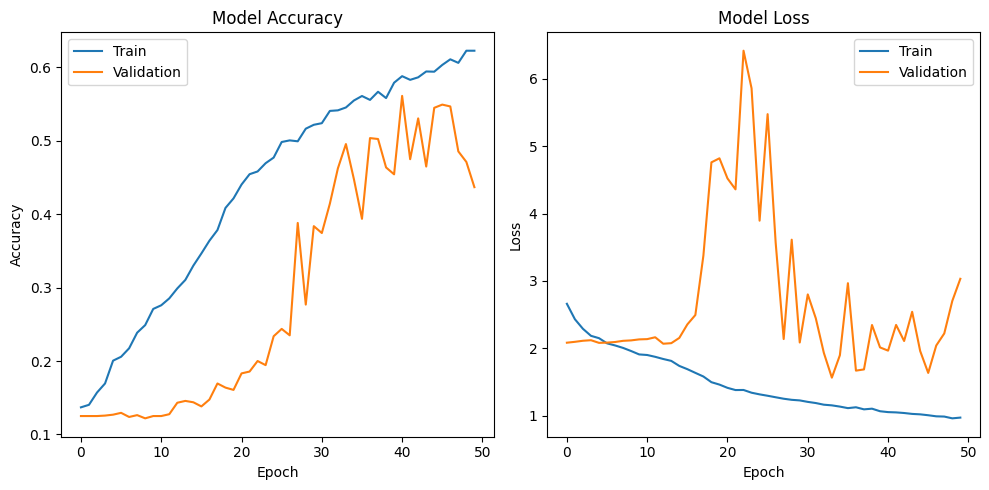

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import json
model.save('/content/drive/MyDrive/Untitled Folder/train_VGGNet_50_epoch.h5')
history_json = json.dumps(train_history.history)
# Save the history to a file
with open('/content/drive/MyDrive/Untitled Folder/train_history_VGGNet_50.json', 'w') as json_file:
    json_file.write(history_json)

<ipython-input-11-2bb4cdc562e9>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_predictions = model.predict_generator(train_generator,num_train)
<ipython-input-11-2bb4cdc562e9>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_predictions = model.predict_generator(validation_generator,num_val)


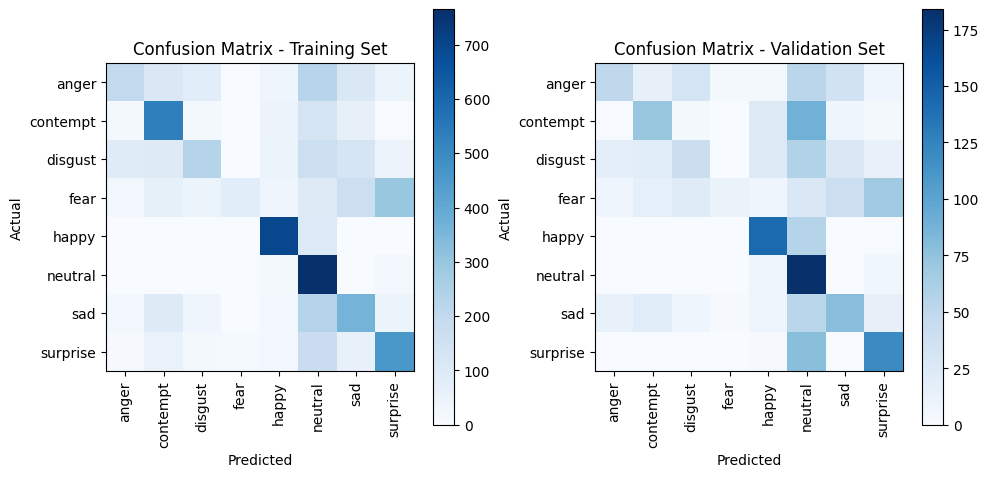

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the predictions for the training set
train_generator.shuffle=False
num_train=train_generator.samples // batch_size
train_predictions = model.predict_generator(train_generator,num_train)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes


# Get the predictions for the validation set
validation_generator.shuffle=False
num_val=validation_generator.samples // batch_size
validation_predictions = model.predict_generator(validation_generator,num_val)
validation_pred_labels = np.argmax(validation_predictions, axis=1)
validation_true_labels = validation_generator.classes

# Create confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.imshow(train_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(train_generator.class_indices)), train_generator.class_indices, rotation=90)
plt.yticks(np.arange(len(train_generator.class_indices)), train_generator.class_indices)
plt.tight_layout()

# Plot confusion matrix for validation set
plt.subplot(1, 2, 2)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.imshow(validation_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(validation_generator.class_indices)), validation_generator.class_indices, rotation=90)
plt.yticks(np.arange(len(validation_generator.class_indices)), validation_generator.class_indices)
plt.tight_layout()

plt.show()


In [ ]:
train_generator.shuffle=False

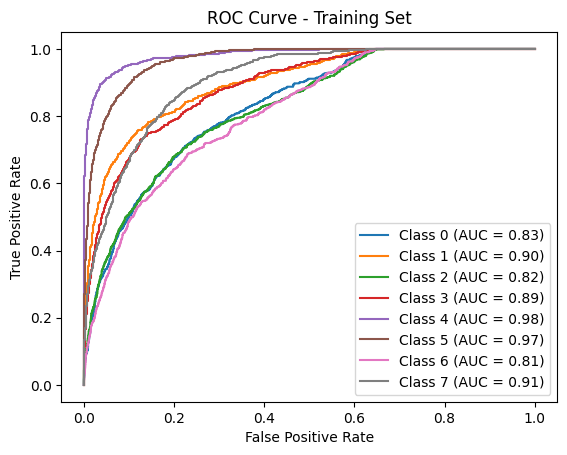

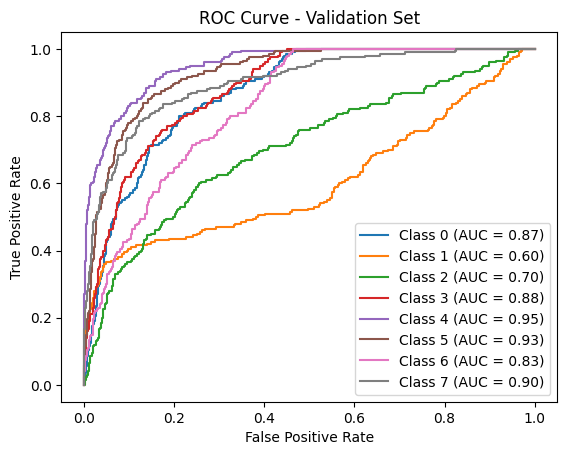

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get the true labels in binary format for train and validation sets
train_true_labels_binary = label_binarize(train_true_labels, classes=np.unique(train_true_labels))
validation_true_labels_binary = label_binarize(validation_true_labels, classes=np.unique(validation_true_labels))

# Compute ROC curves and AUCs for each class in the training set
train_roc_auc = []
for i in range(len(train_generator.class_indices)):
    fpr, tpr, _ = roc_curve(train_true_labels_binary[:, i], train_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    train_roc_auc.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve - Training Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Compute ROC curves and AUCs for each class in the validation set
validation_roc_auc = []
for i in range(len(validation_generator.class_indices)):
    fpr, tpr, _ = roc_curve(validation_true_labels_binary[:, i], validation_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    validation_roc_auc.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve - Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [13]:
from sklearn.metrics import classification_report

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Generate classification reports for the training and validation sets
train_classification_report = classification_report(train_true_labels, train_pred_labels, target_names=class_labels)
validation_classification_report = classification_report(validation_true_labels, validation_pred_labels, target_names=class_labels)

print("Training Set Classification Report:")
print(train_classification_report)

print("\nValidation Set Classification Report:")
print(validation_classification_report)


Training Set Classification Report:
              precision    recall  f1-score   support

       anger       0.56      0.25      0.35       800
    contempt       0.56      0.66      0.61       800
     disgust       0.56      0.29      0.38       800
        fear       0.85      0.10      0.18       800
       happy       0.77      0.87      0.82       800
     neutral       0.40      0.96      0.57       800
         sad       0.41      0.45      0.43       800
    surprise       0.51      0.57      0.54       800

    accuracy                           0.52      6400
   macro avg       0.58      0.52      0.48      6400
weighted avg       0.58      0.52      0.48      6400


Validation Set Classification Report:
              precision    recall  f1-score   support

       anger       0.56      0.25      0.34       200
    contempt       0.49      0.35      0.41       200
     disgust       0.38      0.20      0.27       200
        fear       0.71      0.06      0.11       200
   

# Tune

In [ ]:
model_path = '/content/drive/MyDrive/Untitled Folder/trian_AlexNet_50_epoch.h5'

# Load the model
model = load_model(model_path)

In [15]:

batch_size=400
epoch=25
# Train the model
tune_history = model.fit(
    Tune_generator,
    steps_per_epoch=Tune_generator.samples // batch_size,
    epochs=epoch,  # You can adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/25
4/4 [==============================] - 24s 6s/step - loss: 1.9852 - accuracy: 0.4087 - val_loss: 4.5080 - val_accuracy: 0.3363
Epoch 2/25
4/4 [==============================] - 19s 6s/step - loss: 1.6912 - accuracy: 0.4256 - val_loss: 2.5785 - val_accuracy: 0.4187
Epoch 3/25
4/4 [==============================] - 19s 6s/step - loss: 1.5209 - accuracy: 0.4256 - val_loss: 6.0898 - val_accuracy: 0.2181
Epoch 4/25
4/4 [==============================] - 21s 6s/step - loss: 1.4519 - accuracy: 0.4331 - val_loss: 9.7924 - val_accuracy: 0.1988
Epoch 5/25
4/4 [==============================] - 19s 6s/step - loss: 1.4172 - accuracy: 0.4613 - val_loss: 10.5886 - val_accuracy: 0.1900
Epoch 6/25
4/4 [==============================] - 19s 6s/step - loss: 1.3747 - accuracy: 0.4712 - val_loss: 8.6084 - val_accuracy: 0.2406
Epoch 7/25
4/4 [==============================] - 19s 6s/step - loss: 1.3390 - accuracy: 0.4925 - val_loss: 6.1704 - val_accuracy: 0.2688
Epoch 8/25
4/4 [=================

In [ ]:
import json
model.save('/content/drive/MyDrive/Untitled Folder/tuned_VGGNet_50_epoch.h5')
history_json = json.dumps(tune_history.history)
# Save the history to a file
with open('/content/drive/MyDrive/Untitled Folder/tuned_history_VGGNet_50.json', 'w') as json_file:
    json_file.write(history_json)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


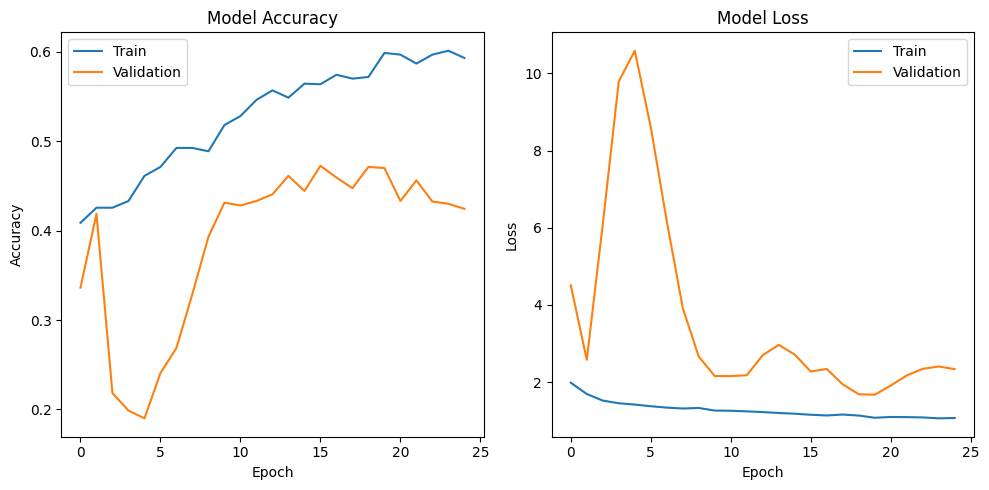

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(tune_history.history['accuracy'])
plt.plot(tune_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(tune_history.history['loss'])
plt.plot(tune_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<ipython-input-18-5ad66083f863>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_predictions = model.predict_generator(Tune_generator,num_train)
<ipython-input-18-5ad66083f863>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  validation_predictions = model.predict_generator(validation_generator,num_val)


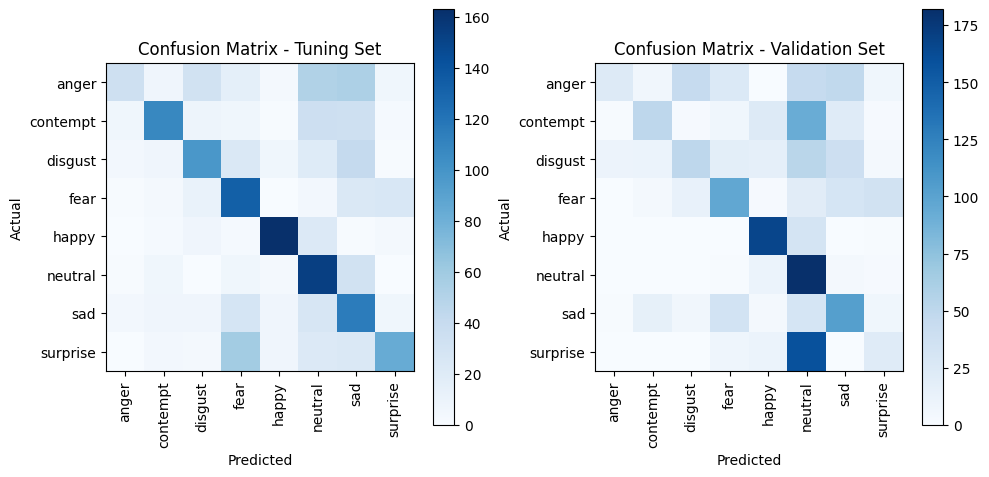

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get the predictions for the training set
Tune_generator.shuffle=False
num_train=Tune_generator.samples // batch_size
train_predictions = model.predict_generator(Tune_generator,num_train)
train_pred_labels = np.argmax(train_predictions, axis=1)
train_true_labels = Tune_generator.classes


# Get the predictions for the validation set
validation_generator.shuffle=False
num_val=validation_generator.samples // batch_size
validation_predictions = model.predict_generator(validation_generator,num_val)
validation_pred_labels = np.argmax(validation_predictions, axis=1)
validation_true_labels = validation_generator.classes

# Create confusion matrices
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Confusion Matrix - Tuning Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.imshow(train_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(Tune_generator.class_indices)), Tune_generator.class_indices, rotation=90)
plt.yticks(np.arange(len(Tune_generator.class_indices)), Tune_generator.class_indices)
plt.tight_layout()

# Plot confusion matrix for validation set
plt.subplot(1, 2, 2)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.imshow(validation_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(validation_generator.class_indices)), validation_generator.class_indices, rotation=90)
plt.yticks(np.arange(len(validation_generator.class_indices)), validation_generator.class_indices)
plt.tight_layout()

plt.show()


In [ ]:
Tune_generator.shuffle=False

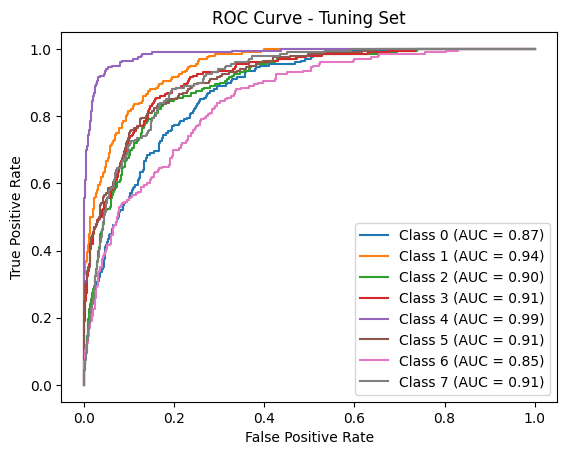

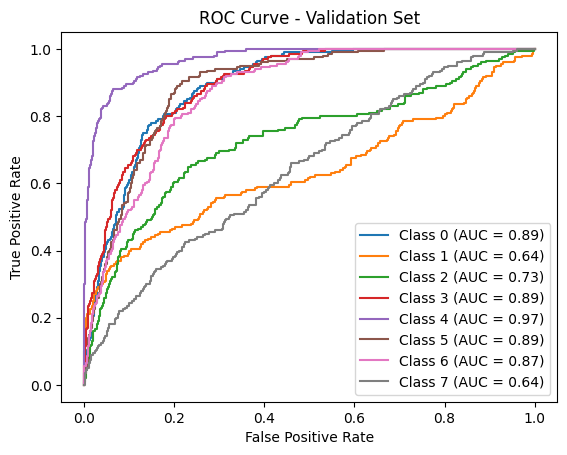

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get the true labels in binary format for train and validation sets
train_true_labels_binary = label_binarize(train_true_labels, classes=np.unique(train_true_labels))
validation_true_labels_binary = label_binarize(validation_true_labels, classes=np.unique(validation_true_labels))

# Compute ROC curves and AUCs for each class in the training set
train_roc_auc = []
for i in range(len(train_generator.class_indices)):
    fpr, tpr, _ = roc_curve(train_true_labels_binary[:, i], train_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    train_roc_auc.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve - Tuning Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Compute ROC curves and AUCs for each class in the validation set
validation_roc_auc = []
for i in range(len(validation_generator.class_indices)):
    fpr, tpr, _ = roc_curve(validation_true_labels_binary[:, i], validation_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    validation_roc_auc.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve - Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [20]:
from sklearn.metrics import classification_report

# Get class labels
class_labels = list(Tune_generator.class_indices.keys())

# Generate classification reports for the training and validation sets
train_classification_report = classification_report(train_true_labels, train_pred_labels, target_names=class_labels)
validation_classification_report = classification_report(validation_true_labels, validation_pred_labels, target_names=class_labels)

print("Tuning Set Classification Report:")
print(train_classification_report)

print("\nValidation Set Classification Report:")
print(validation_classification_report)


Tuning Set Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.17      0.27       200
    contempt       0.75      0.54      0.63       200
     disgust       0.59      0.49      0.54       200
        fear       0.49      0.67      0.56       200
       happy       0.86      0.81      0.84       200
     neutral       0.46      0.77      0.57       200
         sad       0.36      0.57      0.44       200
    surprise       0.66      0.41      0.51       200

    accuracy                           0.55      1600
   macro avg       0.61      0.55      0.55      1600
weighted avg       0.61      0.55      0.55      1600


Validation Set Classification Report:
              precision    recall  f1-score   support

       anger       0.67      0.12      0.20       200
    contempt       0.59      0.25      0.35       200
     disgust       0.43      0.25      0.32       200
        fear       0.51      0.48      0.49       200
     